### Imports and Hyperparameters

In [1]:
import imgaug as ia
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import tensorflow as tf

root_path = os.path.abspath(os.path.join('..'))
if root_path not in sys.path:
    sys.path.append(root_path)

%matplotlib inline

In [2]:
IMAGE_SIZE = (320, 320)
CLASSES = ['background', 'qr_code']
SHUFFLE_BUFFER = 100
BATCH_SIZE = 16
NUM_EPOCHS = 50

### A visualization helper function

In [3]:
def display_image(image, boxes=None, box_color=[0, 0, 255], box_thickness=3, ax=None):
    image = np.array(image)
    
    if boxes is not None:
        boxes = np.array(boxes)[..., :5]
        boxes = [ia.BoundingBox(x1=x1, y1=y1, x2=x2, y2=y2, label=CLASSES[int(label)])
                 for x1, y1, x2, y2, label in boxes]
        boxes = ia.BoundingBoxesOnImage(boxes, shape=image.shape)
        image = boxes.draw_on_image(image, color=box_color,
                                    size=box_thickness)
    
    if ax is None:
        plt.imshow(image)
        plt.axis('off')
        plt.show()
    else:
        ax.imshow(image)
        ax.axis('off')

### Load and visualize some image

Visualize some images with their boxes for sanity checking 

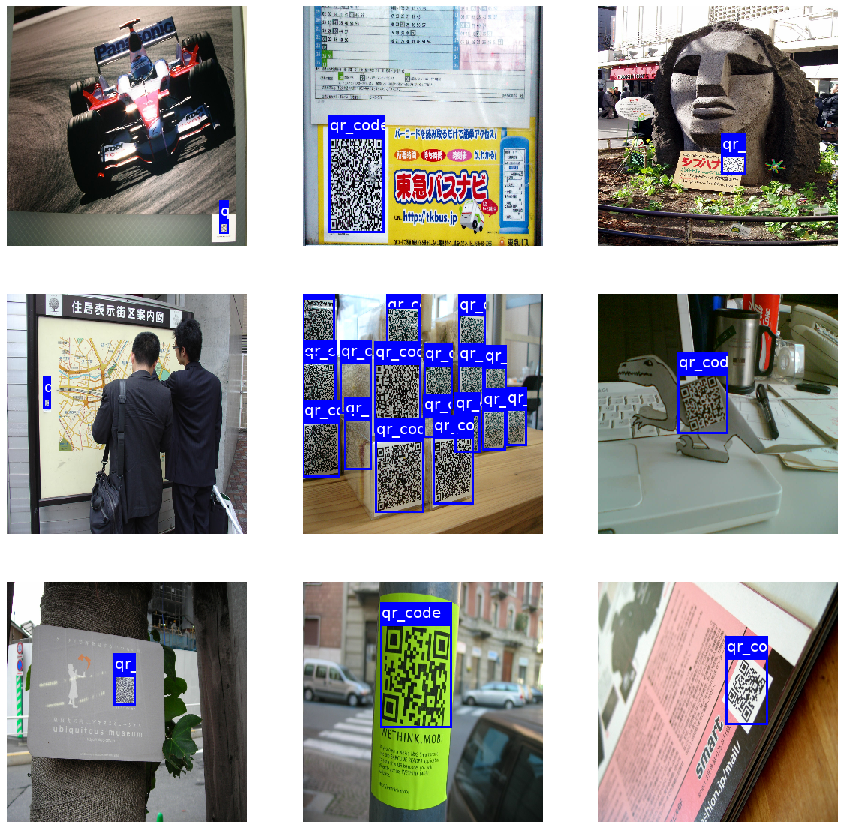

In [4]:
from qr_codes_loader import load_qr_codes_dataset, read_and_resize_image

train_data = load_qr_codes_dataset(split='train')
test_data = load_qr_codes_dataset(split='test')

num_display = 9
num_cols = 3
num_rows = (num_display+1) // num_cols

fig, _ = plt.subplots(num_rows, num_cols, figsize=(5*num_cols, 5*num_rows))

#train_data = train_data.batch(10)
data_iter = iter(train_data)

for idx in range(num_display):
    x, y = next(data_iter)
    x, y = read_and_resize_image(x, y, new_size=IMAGE_SIZE)
    display_image(x, y.to_tensor(), ax=fig.axes[idx])
    
plt.show()

## MobileNet

### Instantiate the model

In [5]:
from ssd_utils.networks.ssd_mobilenet import SSDMobileNet

model = SSDMobileNet(num_classes=len(CLASSES), name='ssd_mobilenet')

### Encode the data for this model

In [6]:
from ssd_utils import output_encoder

anchors = model.get_anchors(image_shape=IMAGE_SIZE + (3,))

def encode(image, boxes):
    encoded = output_encoder.encode(boxes,
                                    anchors=anchors,
                                    model=model)
    return image, encoded

data_iter = iter(train_data)
x, y = next(data_iter)
x, y = read_and_resize_image(x, y, new_size=IMAGE_SIZE)
x, y = encode(x, y.to_tensor())
print(x.shape, y.shape)

(320, 320, 3) (3000, 6)


### Create the data pipelines

In [7]:
batched_train_data = train_data.shuffle(SHUFFLE_BUFFER,
                                        reshuffle_each_iteration=True)
batched_train_data = batched_train_data.map(lambda x, y:
                read_and_resize_image(x, y, new_size=IMAGE_SIZE))
batched_train_data = batched_train_data.map(lambda x, y:
                tf.py_function(encode, [x, y.to_tensor()], [tf.uint8, tf.float32]))
batched_train_data = batched_train_data.batch(BATCH_SIZE).prefetch(5)


batched_test_data = test_data.map(lambda x, y:
                read_and_resize_image(x, y, new_size=IMAGE_SIZE))
batched_test_data = batched_test_data.batch(BATCH_SIZE)

### The training loop

In [9]:
'''model.fit(batched_train_data, epochs=NUM_EPOCHS, callbacks=[
    ValidationMeanAPCallback(model_file='baseline_mobilenet.h5',
                             anchors=anchors,
                             test_dataset=batched_test_data)])
'''

from ssd_utils.ssd_loss import SSDLoss
from ssd_utils.metrics import MeanAveragePrecision
from tensorflow.keras.callbacks import ModelCheckpoint

ssd_loss = SSDLoss()
mean_AP_metric = MeanAveragePrecision()

class ValidationCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        for x, y_true in batched_test_data:
            predictions = [output_encoder.decode(y, anchors, model)
                            for y in model(x)]
            ground_truth = [y.to_tensor() for y in y_true]
            mean_AP_metric.update_state(ground_truth, predictions)
        
        logs['val_meanAP'] = mean_AP_metric.result()
        mean_AP_metric.reset_state()
        
ckpt_callback = ModelCheckpoint('baseline_mobilenet.h5',
                                monitor='val_meanAP',
                                save_best_only=True,
                                save_weights_only=True)        

        
model.compile(optimizer="adam", loss=ssd_loss, run_eagerly=True)

model.fit(batched_train_data, epochs=NUM_EPOCHS,
         callbacks=[ValidationCallback(), ckpt_callback])

Epoch 1/50
Instructions for updating:
Use tf.identity instead.
36/36 [==============================] - ETA: 0s - loss: 44.4700
Calculating Average Precision for class 1.0



36/36 [==============================] - 73s 2s/step - loss: 44.4700 - val_meanAP: 0.2187
Epoch 2/50
36/36 [==============================] - ETA: 0s - loss: 4.1392
Calculating Average Precision for class 1.0



36/36 [==============================] - 34s 936ms/step - loss: 4.1392 - val_meanAP: 0.4138
Epoch 3/50
36/36 [==============================] - ETA: 0s - loss: 1.5658
Calculating Average Precision for class 1.0



36/36 [==============================] - 26s 711ms/step - loss: 1.5658 - val_meanAP: 0.5852
Epoch 4/50
36/36 [==============================] - ETA: 0s - loss: 0.9748
Calculating Average Precision for class 1.0



36/36 [==============================] - 25s 697ms/step - loss: 0.9748 - val_meanAP: 0.6403
Epoch 5/50
36/36 [==============================] - ETA: 0s - loss: 0.7032
Calculating Average Precision for class 1.0



36/36 [==============================] - 25s 691ms/step - loss: 0.7032 - val_meanAP: 0.6633
Epoch 6/50
36/36 [==============================] - ETA: 0s - loss: 0.6069
Calculating Average Precision for class 1.0



36/36 [==============================] - 25s 697ms/step - loss: 0.6069 - val_meanAP: 0.6746
Epoch 7/50
36/36 [==============================] - ETA: 0s - loss: 0.4693
Calculating Average Precision for class 1.0



36/36 [==============================] - 25s 689ms/step - loss: 0.4693 - val_meanAP: 0.6519
Epoch 8/50
36/36 [==============================] - ETA: 0s - loss: 0.3969
Calculating Average Precision for class 1.0



36/36 [==============================] - 25s 688ms/step - loss: 0.3969 - val_meanAP: 0.6289
Epoch 9/50
36/36 [==============================] - ETA: 0s - loss: 0.3771
Calculating Average Precision for class 1.0



36/36 [==============================] - 25s 700ms/step - loss: 0.3771 - val_meanAP: 0.6337
Epoch 10/50
36/36 [==============================] - ETA: 0s - loss: 0.3385
Calculating Average Precision for class 1.0



36/36 [==============================] - 25s 695ms/step - loss: 0.3385 - val_meanAP: 0.6608
Epoch 11/50
36/36 [==============================] - ETA: 0s - loss: 0.2843
Calculating Average Precision for class 1.0



36/36 [==============================] - 25s 697ms/step - loss: 0.2843 - val_meanAP: 0.6329
Epoch 12/50
36/36 [==============================] - ETA: 0s - loss: 0.2546
Calculating Average Precision for class 1.0



36/36 [==============================] - 25s 693ms/step - loss: 0.2546 - val_meanAP: 0.6685
Epoch 13/50
36/36 [==============================] - ETA: 0s - loss: 0.2281
Calculating Average Precision for class 1.0



36/36 [==============================] - 25s 688ms/step - loss: 0.2281 - val_meanAP: 0.6626
Epoch 14/50
36/36 [==============================] - ETA: 0s - loss: 0.2071
Calculating Average Precision for class 1.0



36/36 [==============================] - 25s 684ms/step - loss: 0.2071 - val_meanAP: 0.6257
Epoch 15/50
36/36 [==============================] - ETA: 0s - loss: 0.1945
Calculating Average Precision for class 1.0



36/36 [==============================] - 25s 700ms/step - loss: 0.1945 - val_meanAP: 0.6574
Epoch 16/50
36/36 [==============================] - ETA: 0s - loss: 0.1827
Calculating Average Precision for class 1.0



36/36 [==============================] - 25s 682ms/step - loss: 0.1827 - val_meanAP: 0.6537
Epoch 17/50
36/36 [==============================] - ETA: 0s - loss: 0.1865
Calculating Average Precision for class 1.0



36/36 [==============================] - 25s 694ms/step - loss: 0.1865 - val_meanAP: 0.6714
Epoch 18/50
36/36 [==============================] - ETA: 0s - loss: 0.2048
Calculating Average Precision for class 1.0



36/36 [==============================] - 25s 691ms/step - loss: 0.2048 - val_meanAP: 0.6644
Epoch 19/50
36/36 [==============================] - ETA: 0s - loss: 0.1700
Calculating Average Precision for class 1.0



36/36 [==============================] - 25s 693ms/step - loss: 0.1700 - val_meanAP: 0.6788
Epoch 20/50
36/36 [==============================] - ETA: 0s - loss: 0.1762
Calculating Average Precision for class 1.0



36/36 [==============================] - 25s 686ms/step - loss: 0.1762 - val_meanAP: 0.6629
Epoch 21/50
36/36 [==============================] - ETA: 0s - loss: 0.1685
Calculating Average Precision for class 1.0



36/36 [==============================] - 25s 698ms/step - loss: 0.1685 - val_meanAP: 0.6761
Epoch 22/50
36/36 [==============================] - ETA: 0s - loss: 0.1487
Calculating Average Precision for class 1.0



36/36 [==============================] - 25s 684ms/step - loss: 0.1487 - val_meanAP: 0.6842
Epoch 23/50
36/36 [==============================] - ETA: 0s - loss: 0.1451
Calculating Average Precision for class 1.0



36/36 [==============================] - 25s 690ms/step - loss: 0.1451 - val_meanAP: 0.6735
Epoch 24/50
36/36 [==============================] - ETA: 0s - loss: 0.1533
Calculating Average Precision for class 1.0



36/36 [==============================] - 25s 693ms/step - loss: 0.1533 - val_meanAP: 0.6504
Epoch 25/50
36/36 [==============================] - ETA: 0s - loss: 0.1523
Calculating Average Precision for class 1.0



36/36 [==============================] - 25s 696ms/step - loss: 0.1523 - val_meanAP: 0.6643
Epoch 26/50
36/36 [==============================] - ETA: 0s - loss: 0.1402
Calculating Average Precision for class 1.0



36/36 [==============================] - 25s 690ms/step - loss: 0.1402 - val_meanAP: 0.6818
Epoch 27/50
36/36 [==============================] - ETA: 0s - loss: 0.1440
Calculating Average Precision for class 1.0



36/36 [==============================] - 25s 684ms/step - loss: 0.1440 - val_meanAP: 0.6814
Epoch 28/50
36/36 [==============================] - ETA: 0s - loss: 0.1433
Calculating Average Precision for class 1.0



36/36 [==============================] - 25s 694ms/step - loss: 0.1433 - val_meanAP: 0.6976
Epoch 29/50
36/36 [==============================] - ETA: 0s - loss: 0.1397
Calculating Average Precision for class 1.0



36/36 [==============================] - 25s 685ms/step - loss: 0.1397 - val_meanAP: 0.7013
Epoch 30/50
36/36 [==============================] - ETA: 0s - loss: 0.1354
Calculating Average Precision for class 1.0



36/36 [==============================] - 25s 690ms/step - loss: 0.1354 - val_meanAP: 0.7032
Epoch 31/50
36/36 [==============================] - ETA: 0s - loss: 0.1247
Calculating Average Precision for class 1.0



36/36 [==============================] - 25s 686ms/step - loss: 0.1247 - val_meanAP: 0.7030
Epoch 32/50
36/36 [==============================] - ETA: 0s - loss: 0.1230
Calculating Average Precision for class 1.0



36/36 [==============================] - 25s 693ms/step - loss: 0.1230 - val_meanAP: 0.7098
Epoch 33/50
36/36 [==============================] - ETA: 0s - loss: 0.1215
Calculating Average Precision for class 1.0



36/36 [==============================] - 25s 686ms/step - loss: 0.1215 - val_meanAP: 0.6857
Epoch 34/50
36/36 [==============================] - ETA: 0s - loss: 0.1193
Calculating Average Precision for class 1.0



36/36 [==============================] - 25s 690ms/step - loss: 0.1193 - val_meanAP: 0.7030
Epoch 35/50
36/36 [==============================] - ETA: 0s - loss: 0.1148
Calculating Average Precision for class 1.0



36/36 [==============================] - 25s 694ms/step - loss: 0.1148 - val_meanAP: 0.7109
Epoch 36/50
36/36 [==============================] - ETA: 0s - loss: 0.1118
Calculating Average Precision for class 1.0



36/36 [==============================] - 25s 696ms/step - loss: 0.1118 - val_meanAP: 0.6764
Epoch 37/50
36/36 [==============================] - ETA: 0s - loss: 0.1078
Calculating Average Precision for class 1.0



36/36 [==============================] - 25s 706ms/step - loss: 0.1078 - val_meanAP: 0.7128
Epoch 38/50
36/36 [==============================] - ETA: 0s - loss: 0.1157
Calculating Average Precision for class 1.0



36/36 [==============================] - 25s 693ms/step - loss: 0.1157 - val_meanAP: 0.6950
Epoch 39/50
36/36 [==============================] - ETA: 0s - loss: 0.1281
Calculating Average Precision for class 1.0



36/36 [==============================] - 25s 703ms/step - loss: 0.1281 - val_meanAP: 0.7074
Epoch 40/50
36/36 [==============================] - ETA: 0s - loss: 0.1274
Calculating Average Precision for class 1.0



36/36 [==============================] - 25s 689ms/step - loss: 0.1274 - val_meanAP: 0.7148
Epoch 41/50
36/36 [==============================] - ETA: 0s - loss: 0.1159
Calculating Average Precision for class 1.0



36/36 [==============================] - 25s 686ms/step - loss: 0.1159 - val_meanAP: 0.6950
Epoch 42/50
36/36 [==============================] - ETA: 0s - loss: 0.1068
Calculating Average Precision for class 1.0



36/36 [==============================] - 25s 690ms/step - loss: 0.1068 - val_meanAP: 0.7019
Epoch 43/50
36/36 [==============================] - ETA: 0s - loss: 0.1060
Calculating Average Precision for class 1.0



36/36 [==============================] - 25s 692ms/step - loss: 0.1060 - val_meanAP: 0.7001
Epoch 44/50
36/36 [==============================] - ETA: 0s - loss: 0.1131
Calculating Average Precision for class 1.0



36/36 [==============================] - 25s 702ms/step - loss: 0.1131 - val_meanAP: 0.6809
Epoch 45/50
36/36 [==============================] - ETA: 0s - loss: 0.1057
Calculating Average Precision for class 1.0



36/36 [==============================] - 25s 684ms/step - loss: 0.1057 - val_meanAP: 0.6874
Epoch 46/50
36/36 [==============================] - ETA: 0s - loss: 0.0999
Calculating Average Precision for class 1.0



36/36 [==============================] - 25s 700ms/step - loss: 0.0999 - val_meanAP: 0.6902
Epoch 47/50
36/36 [==============================] - ETA: 0s - loss: 0.1007
Calculating Average Precision for class 1.0



36/36 [==============================] - 25s 692ms/step - loss: 0.1007 - val_meanAP: 0.6791
Epoch 48/50
36/36 [==============================] - ETA: 0s - loss: 0.1060
Calculating Average Precision for class 1.0



36/36 [==============================] - 25s 698ms/step - loss: 0.1060 - val_meanAP: 0.6954
Epoch 49/50
36/36 [==============================] - ETA: 0s - loss: 0.1039
Calculating Average Precision for class 1.0



36/36 [==============================] - 25s 699ms/step - loss: 0.1039 - val_meanAP: 0.6778
Epoch 50/50
36/36 [==============================] - ETA: 0s - loss: 0.1065
Calculating Average Precision for class 1.0



36/36 [==============================] - 25s 692ms/step - loss: 0.1065 - val_meanAP: 0.6974


In [ ]:
model_file = 'baseline_mobilenet.h5'
model.load_weights(model_file)

from ssd_utils.metrics import mean_AP

ground_truth, predictions = [], []
        
for x, y_true in batched_test_data:
    predictions += [output_encoder.decode(y, anchors, model, nms_threshold=0.2)
                    for y in model(x)]
    ground_truth += [y.to_tensor() for y in y_true]

print('Validation meanAP:', mean_AP(ground_truth, predictions))

num_display = 16
num_cols = 3
num_rows = (num_display+num_cols-1) // num_cols

fig, _ = plt.subplots(num_rows, num_cols, figsize=(5*num_cols, 5*num_rows))

data_iter = iter(batched_test_data)
X, Y = next(data_iter)

for idx in range(num_display):
    x, y = X[idx], predictions[idx]
    display_image(x, y, ax=fig.axes[idx])
    
plt.show()

## ResNet50

### Instantiate the model

In [ ]:
x, y = next(iter(batched_train_data))
print(x.shape, y.shape)

In [ ]:
from ssd_utils.networks.ssd_resnet50 import SSDResNet50

model = SSDResNet50(num_classes=len(CLASSES), name='ssd_resnet50')

### Encode the data for this model

In [ ]:
from ssd_utils import output_encoder

anchors = model.get_anchors(image_shape=IMAGE_SIZE + (3,))

def encode(image, boxes):
    encoded = output_encoder.encode(boxes,
                                    anchors=anchors,
                                    model=model)
    return image, encoded

data_iter = iter(train_data)
x, y = next(data_iter)
x, y = read_and_resize_image(x, y, new_size=IMAGE_SIZE)
x, y = encode(x, y.to_tensor())
print(x.shape, y.shape)

### Compile the model and create the data pipeline

In [ ]:
from ssd_utils.ssd_loss import SSDLoss

ssd_loss = SSDLoss()
model.compile(optimizer="adam", loss=ssd_loss, run_eagerly=True)


batched_train_data = train_data.shuffle(SHUFFLE_BUFFER,
                                        reshuffle_each_iteration=True)
batched_train_data = batched_train_data.map(lambda x, y:
                read_and_resize_image(x, y, new_size=IMAGE_SIZE))
batched_train_data = batched_train_data.map(lambda x, y:
                tf.py_function(encode, [x, y.to_tensor()], [tf.uint8, tf.float32]))
batched_train_data = batched_train_data.batch(BATCH_SIZE).prefetch(5)


batched_test_data = test_data.map(lambda x, y:
                read_and_resize_image(x, y, new_size=IMAGE_SIZE))
batched_test_data = batched_test_data.batch(BATCH_SIZE)

### The training loop

In [ ]:
model.fit(batched_train_data, epochs=NUM_EPOCHS, callbacks=[
    ValidationMeanAPCallback(model_file='baseline_resnet50.h5',
                             anchors=anchors,
                             test_dataset=batched_test_data)])

In [ ]:
model_file = 'baseline_resnet50.h5'
model.load_weights(model_file)

from ssd_utils.metrics import mean_AP

ground_truth, predictions = [], []
        
for x, y_true in batched_test_data:
    predictions += [output_encoder.decode(y, anchors, model, nms_threshold=0.2)
                    for y in model(x)]
    ground_truth += [y.to_tensor() for y in y_true]

print('Validation meanAP:', mean_AP(ground_truth, predictions))

num_display = 16
num_cols = 3
num_rows = (num_display+num_cols-1) // num_cols

fig, _ = plt.subplots(num_rows, num_cols, figsize=(5*num_cols, 5*num_rows))

data_iter = iter(batched_test_data)
X, Y = next(data_iter)

for idx in range(num_display):
    x, y = X[idx], predictions[idx]
    display_image(x, y, ax=fig.axes[idx])
    
plt.show()